##SVR

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Annually Mutual Fund Returns.csv")

# Drop unnecessary column
df.drop(columns=['classification'], inplace=True)

# Convert year columns to numeric
year_cols = [str(year) for year in range(2015, 2025)]
df[year_cols] = df[year_cols].apply(pd.to_numeric, errors='coerce')

# Drop early years
df.drop(columns=['2015', '2016', '2017', '2018'], inplace=True)

# Fill missing values with median
for year in ['2019', '2020', '2021', '2022', '2023', '2024']:
    df[year] = df[year].fillna(df[year].median())

# Encode categorical features
df["Fund_Encoded"] = LabelEncoder().fit_transform(df["Fund"])
df["Category_Encoded"] = LabelEncoder().fit_transform(df["Category"])

# Simulate targets
df["Future_3Y_Return"] = df[["2022", "2023", "2024"]].mean(axis=1) + np.random.normal(0, 0.5, len(df))
df["Future_5Y_Return"] = df[["2020", "2021", "2022", "2023", "2024"]].mean(axis=1) + np.random.normal(0, 0.7, len(df))


In [ ]:
features = ["2019", "2020", "2021", "2022", "2023", "2024", "Fund_Encoded", "Category_Encoded"]
target_3y = "Future_3Y_Return"
target_5y = "Future_5Y_Return"

X = df[features]
y_3y = df[target_3y]
y_5y = df[target_5y]


In [ ]:
X_train, X_test, y_train_3y, y_test_3y = train_test_split(X, y_3y, test_size=0.2, random_state=42)
_, _, y_train_5y, y_test_5y = train_test_split(X, y_5y, test_size=0.2, random_state=42)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled_all = scaler.transform(X)  # for full prediction


In [ ]:
'''def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return np.mean(np.abs(y_true - y_pred) / np.clip(denominator, 1e-8, None)) * 100'''

def evaluate(y_true, y_pred, label=""):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    smape_val = smape(y_true, y_pred)
    accuracy = 100 - smape_val

    print(f"\n📊 {label} R² Score: {r2:.4f}")
    print(f"📊 {label} MAE: {mae:.4f}")
    print(f"📊 {label} MSE: {mse:.4f}")
    print(f"📊 {label} RMSE: {rmse:.4f}")
    #print(f"📊 {label} SMAPE: {smape_val:.2f}%")
    print(f"✅ {label} Accuracy: {accuracy:.2f}%")


In [ ]:
# 3-Year Return Prediction
model_3y = SVR()
model_3y.fit(X_train_scaled, y_train_3y)
pred_3y = model_3y.predict(X_test_scaled)
evaluate(y_test_3y, pred_3y, "3-Year")

# 5-Year Return Prediction
model_5y = SVR()
model_5y.fit(X_train_scaled, y_train_5y)
pred_5y = model_5y.predict(X_test_scaled)
evaluate(y_test_5y, pred_5y, "5-Year")



📊 3-Year R² Score: 0.8335
📊 3-Year MAE: 1.0324
📊 3-Year MSE: 7.3347
📊 3-Year RMSE: 2.7083
✅ 3-Year Accuracy: 91.04%

📊 5-Year R² Score: 0.8761
📊 5-Year MAE: 1.1213
📊 5-Year MSE: 5.4029
📊 5-Year RMSE: 2.3244
✅ 5-Year Accuracy: 90.07%


In [ ]:
# Predict on the full dataset
df["Predicted_3Y_Return"] = model_3y.predict(X_scaled_all)
df["Predicted_5Y_Return"] = model_5y.predict(X_scaled_all)

# Prediction function
def predict_for_fund(fund_name):
    fund_row = df[df["Fund"] == fund_name]
    if fund_row.empty:
        print(f"⚠️ Fund '{fund_name}' not found.")
    else:
        pred_3y = fund_row["Predicted_3Y_Return"].values[0]
        pred_5y = fund_row["Predicted_5Y_Return"].values[0]
        print(f"\n🔮 Fund: {fund_name}")
        print(f"📈 Predicted 3-Year Return: {pred_3y:.2f}%")
        print(f"📈 Predicted 5-Year Return: {pred_5y:.2f}%")

# Example usage
predict_for_fund("UTI ELSS Tax Saver Fund Reg(G)")



🔮 Fund: UTI ELSS Tax Saver Fund Reg(G)
📈 Predicted 3-Year Return: 11.85%
📈 Predicted 5-Year Return: 17.58%


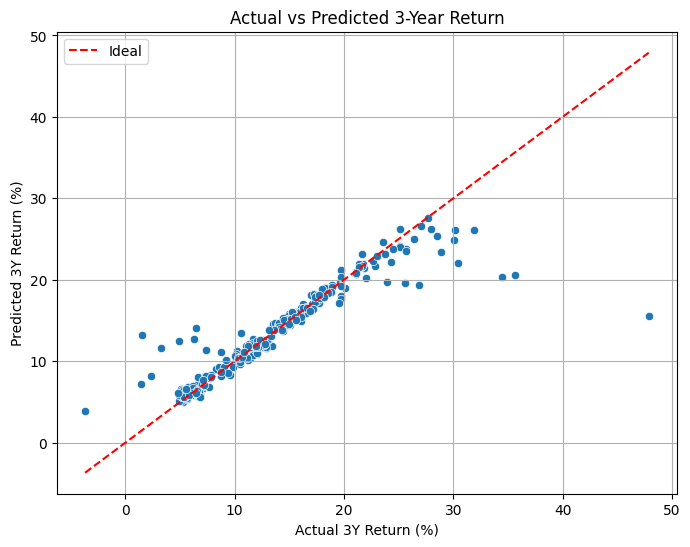

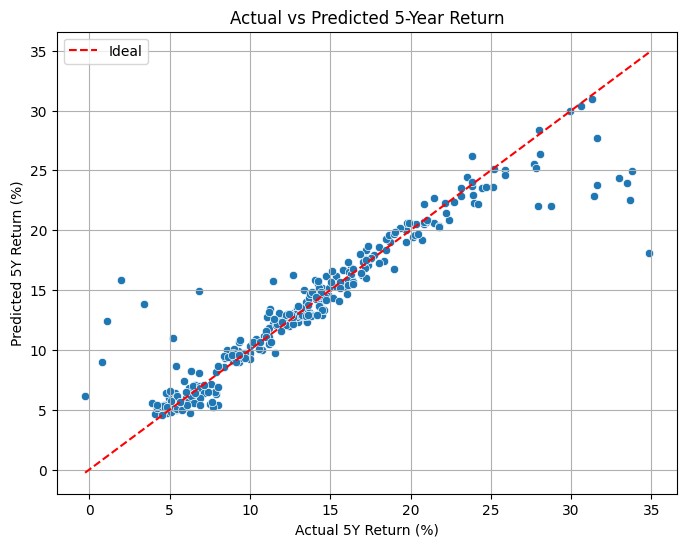

In [ ]:
# 3-Year Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_3y, y=pred_3y)
plt.plot([y_test_3y.min(), y_test_3y.max()], [y_test_3y.min(), y_test_3y.max()],
         'r--', label="Ideal")
plt.title("Actual vs Predicted 3-Year Return")
plt.xlabel("Actual 3Y Return (%)")
plt.ylabel("Predicted 3Y Return (%)")
plt.legend()
plt.grid(True)
plt.show()

# 5-Year Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_5y, y=pred_5y)
plt.plot([y_test_5y.min(), y_test_5y.max()], [y_test_5y.min(), y_test_5y.max()],
         'r--', label="Ideal")
plt.title("Actual vs Predicted 5-Year Return")
plt.xlabel("Actual 5Y Return (%)")
plt.ylabel("Predicted 5Y Return (%)")
plt.legend()
plt.grid(True)
plt.show()


##Results

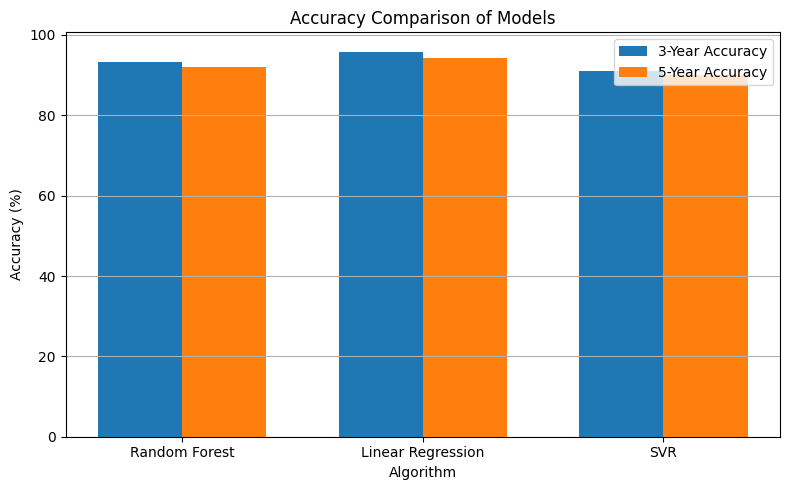

In [ ]:
import matplotlib.pyplot as plt

algorithms = ['Random Forest', 'Linear Regression', 'SVR']
acc_3y = [93.24, 95.87, 91.04]
acc_5y = [92.02, 94.21, 90.07]

plt.figure(figsize=(8, 5))
bar_width = 0.35
index = range(len(algorithms))

plt.bar(index, acc_3y, bar_width, label='3-Year Accuracy')
plt.bar([i + bar_width for i in index], acc_5y, bar_width, label='5-Year Accuracy')

plt.xlabel('Algorithm')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison of Models')
plt.xticks([i + bar_width / 2 for i in index], algorithms)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


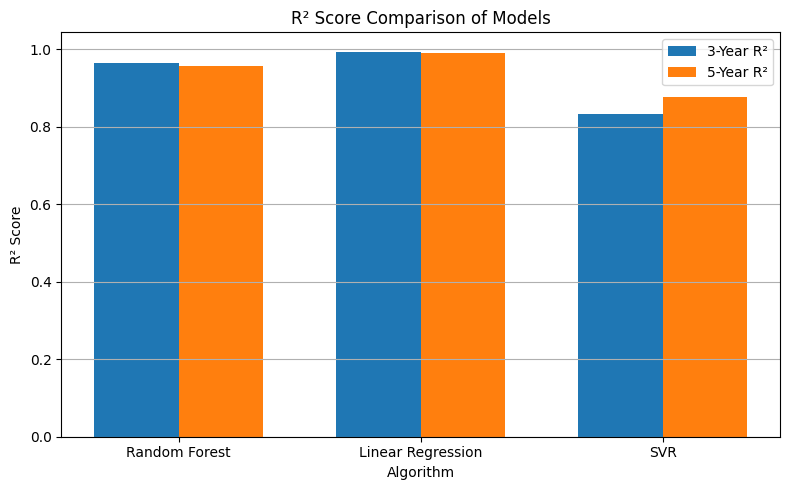

In [ ]:
r2_3y = [0.9647, 0.9943, 0.8335]
r2_5y = [0.9559, 0.9897, 0.8761]

plt.figure(figsize=(8, 5))
plt.bar(index, r2_3y, bar_width, label='3-Year R²')
plt.bar([i + bar_width for i in index], r2_5y, bar_width, label='5-Year R²')

plt.xlabel('Algorithm')
plt.ylabel('R² Score')
plt.title('R² Score Comparison of Models')
plt.xticks([i + bar_width / 2 for i in index], algorithms)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


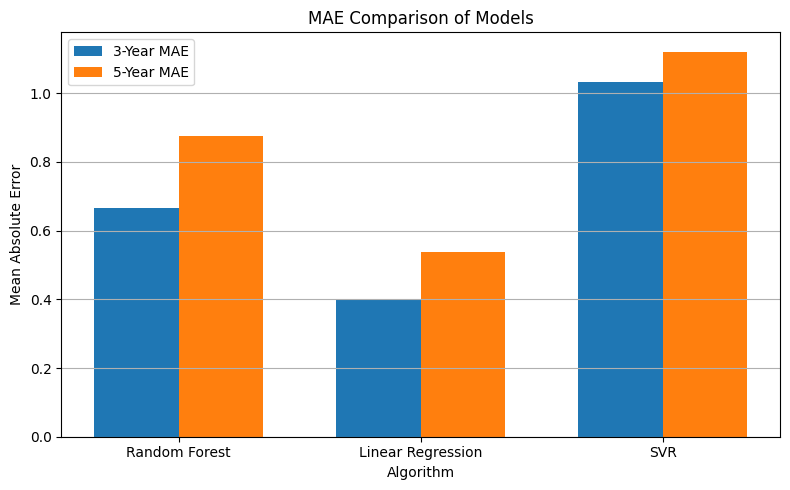

In [ ]:
mae_3y = [0.6662, 0.3986, 1.0324]
mae_5y = [0.8767, 0.5385, 1.1213]

plt.figure(figsize=(8, 5))
plt.bar(index, mae_3y, bar_width, label='3-Year MAE')
plt.bar([i + bar_width for i in index], mae_5y, bar_width, label='5-Year MAE')

plt.xlabel('Algorithm')
plt.ylabel('Mean Absolute Error')
plt.title('MAE Comparison of Models')
plt.xticks([i + bar_width / 2 for i in index], algorithms)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()
